## Импорт

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RANDOM_STATE=1234
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

## Разведочный анализ данных

### Общая информация, целевой признак.

In [2]:
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
293,63.0,1,103,1,35,0,179000.00,0.90,136,1,1,270,0
132,46.0,0,719,0,40,1,263358.03,1.18,137,0,0,107,0
69,65.0,0,113,1,25,0,497000.00,1.83,135,1,0,67,1
170,51.0,1,582,1,35,0,263358.03,1.50,136,1,1,145,0
187,60.0,0,1896,1,25,0,365000.00,2.10,144,0,0,172,1
157,50.0,0,250,0,25,0,262000.00,1.00,136,1,1,120,0
144,72.0,1,943,0,25,1,338000.00,1.70,139,1,1,111,1
179,55.0,0,835,0,40,0,279000.00,0.70,140,1,1,147,0


In [3]:
data = data.rename(columns = {'DEATH_EVENT':'death_event'})

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Признаки в основном целочисленные, три с плавающей запятой, но к ним надо присмотреться, потому что два из них можно попробовать перевести в целочисленные.

- `age` - возраст пациента (0-120, старше и младше не бывает)
- `anaemia` - снижение показателей красных кровяных телец или гемоглобина (бинарный)
- `creatinine_phosphokinase` - уровень фермента КФК в крови (мкг/л)
- `diabetes` - наличие диабета (бинарный)
- `ejection_fraction` - процент крови, покидающей сердце при каждом сокращении (в процентах, диапазон значений от 0 до 100)
- `high_blood_pressure` - наличие гипертонии (бинарный)
- `platelets` - тромбоциты в крови (1000/мл)
- `serum_creatinine` - уровень сывороточного креатинина в крови (мг/дл)
- `serum_sodium` - уровень сывороточного натрия в крови (мэкв/л)
- `sex` - женщина или мужчина (бинарный)
- `smoking` - курит пациент или нет (бинарный)
- `time` - период наблюдения (дни) 
- `DEATH_EVENT` - целевой признак, пациент умер в течение периода наблюдения (бинарный)

Все признаки должны быть неотрицательными.
Взглянем на них.

In [5]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Да, все неотрицательные, в допустимых диапазонах (для тех значений, которые мы обозначили ранее).


In [6]:
data.duplicated().sum()

0

Дублей не наблюдается.
Построим матрицу корреляций.

<AxesSubplot:>

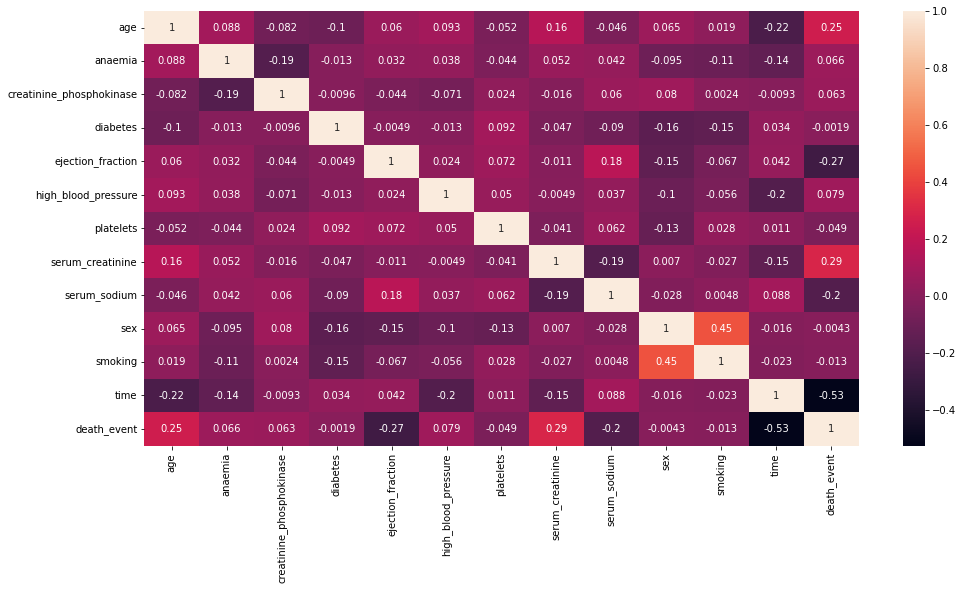

In [7]:
correlation_matrix = data.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Видим, что положительная корреляция есть между полом и курением, а также между временем наблюдения и целевым признаком. Также наблюдаем несколько ощутимую связь между целевым признаком и возрастом, уровнем креатинина и натрия (разнонаправленные) и размером выброса крови при сокращении сердца. 

Пропуски

In [8]:
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
death_event                 0
dtype: int64

Пропусков нет.

Преобразуем тип данных столбца age.

In [9]:
data['age'] = data['age'].astype(int)

Для начала посмотрим как выглядит целевой признак, то есть оценим соотношение событий. 

<AxesSubplot:xlabel='death_event', ylabel='count'>

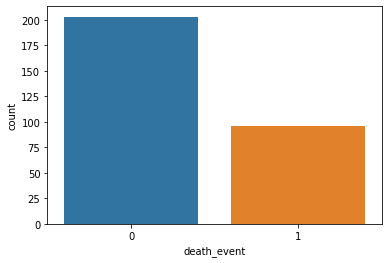

In [10]:
#sns.countplot('death_event', data=data)
sns.countplot(x=data['death_event'])

Зафиксированых случаев смерти почти в два раза меньше чем случев с положительным исходом, таким образом имеется явный дисбаланс классов. А значит и дальнейшая работа будет затруднена, например прогнозы будут более благоприятные, то есть смещаться в сторону отсутствия смерти от сердечной недостаточности.

Посмотрим как распределены сами признаки. Для удобства восприятия сначала отобразим распределение категориальных признаков, затем числовых.
К категориальным относятся: наличие анемии, диабета, высокого давления, а так же пол и факт курения.
К числовым все оставшиеся.

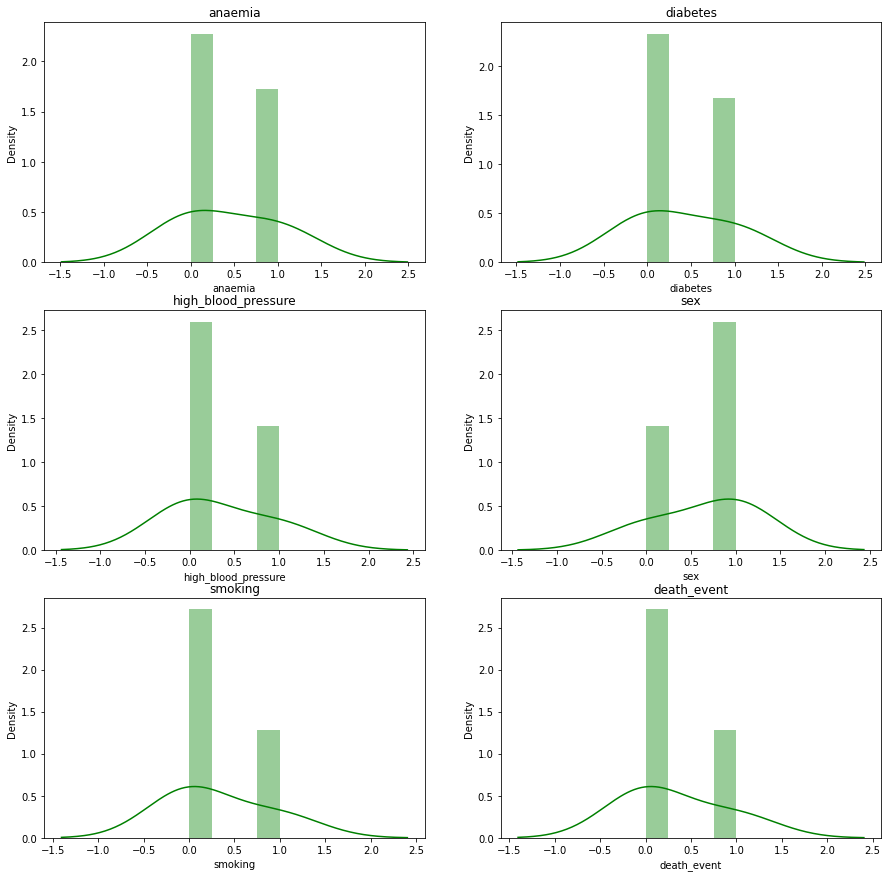

In [11]:
#категориальные признаки
list_of_categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'death_event']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,15))
for i in range(len(list_of_categorical_features)):
    plt.subplot(3,2,i+1)
    sns.distplot(data[list_of_categorical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_categorical_features[i]
    plt.title(title)

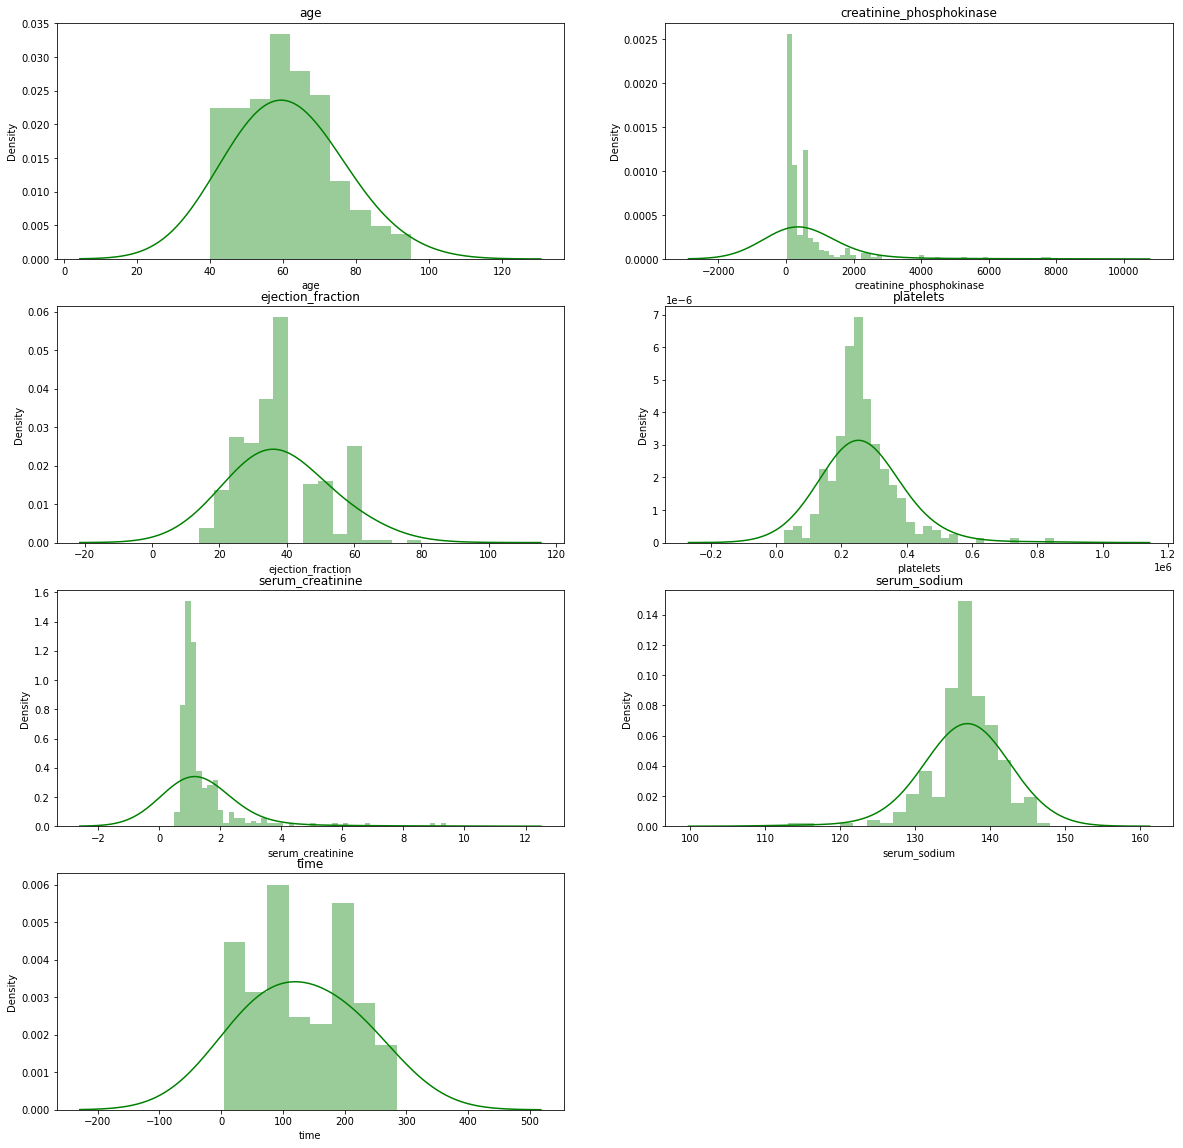

In [12]:
#числовые признаки
list_of_numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,20))
for i in range(len(list_of_numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(data[list_of_numerical_features[i]],color = 'g', kde_kws = {'bw' : True});
    title = list_of_numerical_features[i]
    plt.title(title)

Итак, почти все признаки распределены нормально, за исключением, например, времени или уровня сывороточного натрия/креатина.

Далее следует посмотреть на то как зависит, например, факт смерти от факта наличия анемии и тд... Для числовых признаков аналогично

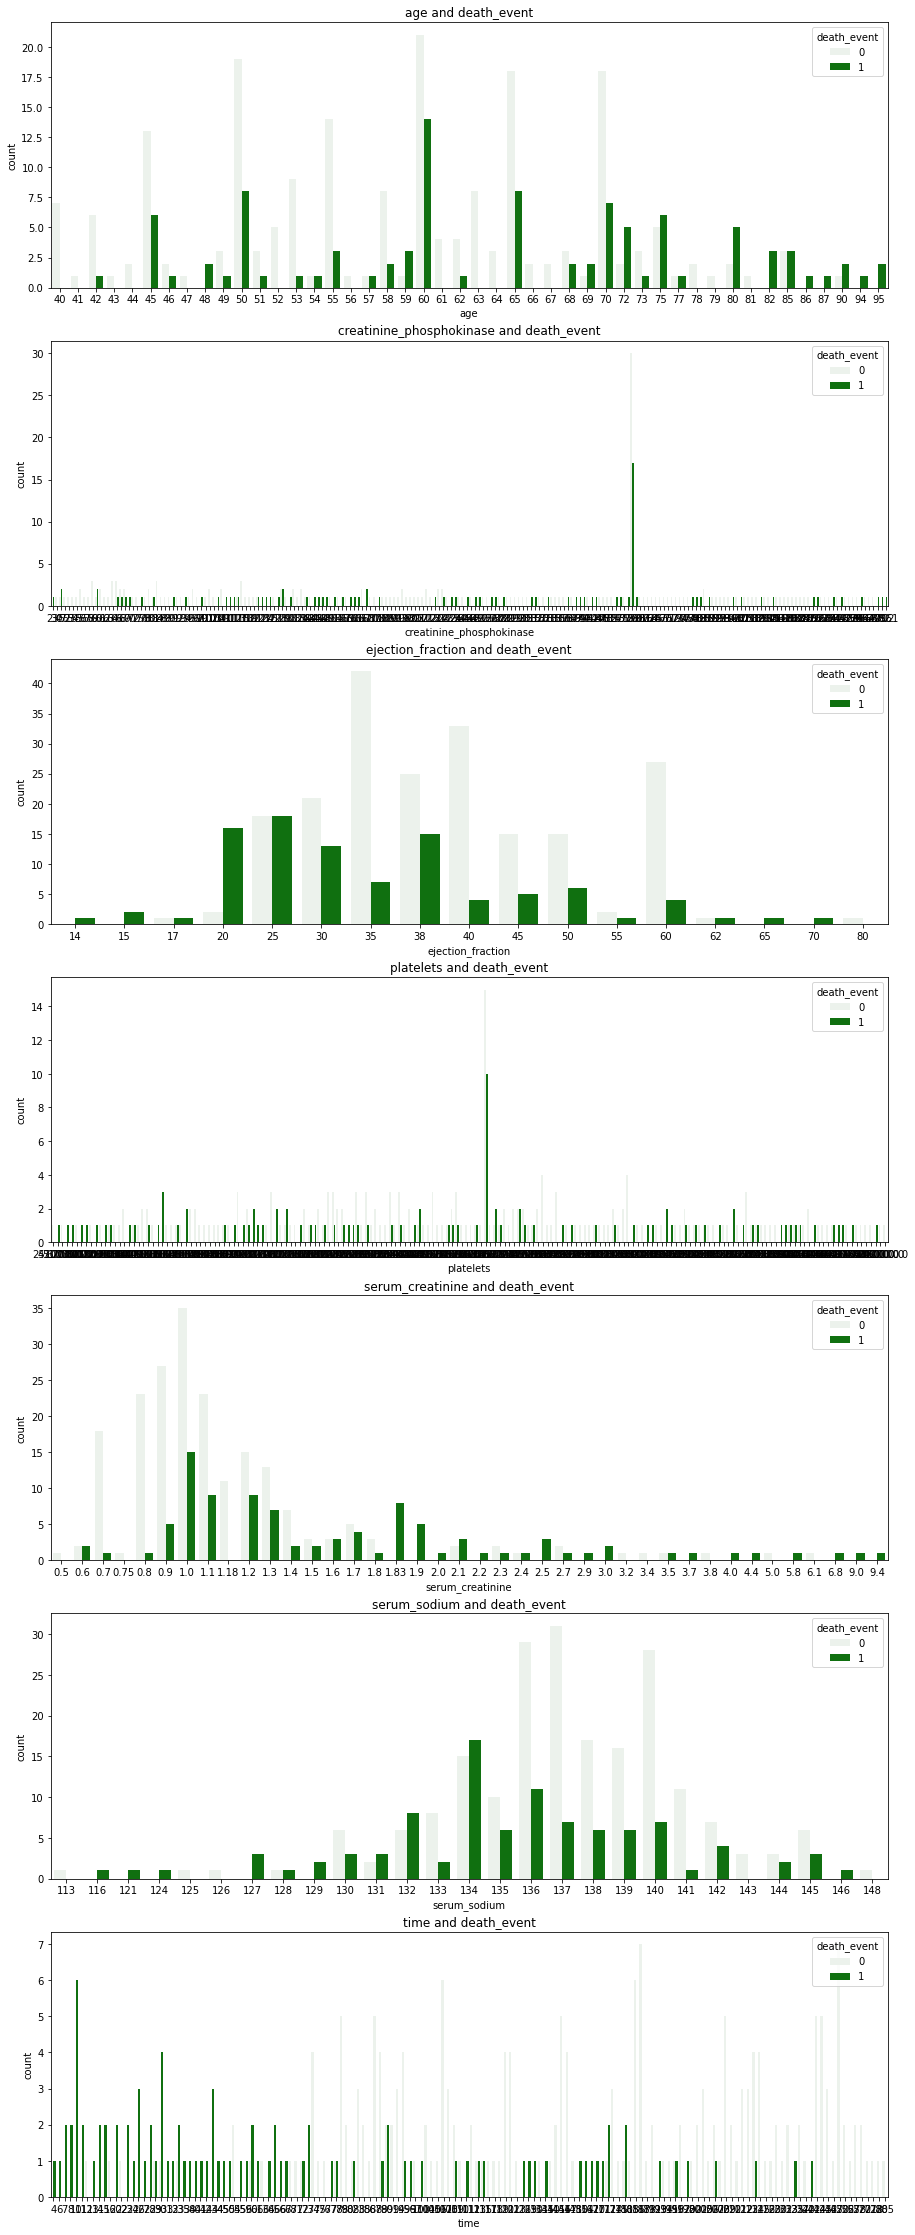

In [13]:
fig, ax = plt.subplots(nrows = 7,ncols = 1,figsize = (15,40))
for i in range(len(list_of_numerical_features)):
    plt.subplot(7,1,i+1)
    sns.countplot(x = data[list_of_numerical_features[i]],data=data, hue='death_event',color = 'g');
    title = list_of_numerical_features[i] + ' and death_event' 
    plt.title(title)

На графиках по оси х слишком много точек, поэтому их сложно итерпретировать, возможно,  в этих случаях более информативными будут другие виды графикв...

Но однозначно можно сказать, что мы наблюдаем увеличение смертности начиная с 42 лет. Пики смертности приходятся на вораст 45, 50,60 65, 70, 72 75 и 80 лет.
Повышается риск смертности при проценте крови, покидающей сердце при каждом сокращении, равном от 20 до 60. Пики приходятся на процент равный 20, 25, 30 и 38.
При уровене сывороточного креатинина в крови начиная с 0.6 до 3.0, мы видим рост смертности, ощутымый рост приходится на значения 0.9-1.1, 1.2 и 1.3, 1,83, 1.9.
Уровень сывороточного натрия начиная с 127 - 145 свидетельсьтвует о риске смертности.

#### Если попробовать посчитать процент смертнности для числовых признаков так? вместо того, что сверху. можно конечно поиграться с типами графиков....???

#### А какая цель вообще у визуализации? Можно отобразить разными способами и рассказать разные вещи о параметрах.


#### У нас есть пунктик - накидать новых параметров. Мне кажется, что смертность - это уже новый параметр. Мы можем вообще заменить предложенные фичи на их производные - вот эту смертность.

,number_of_death,number_of_observations,mortality_rate
age,,,
40,0,7,0.0
41,0,1,0.0
42,1,7,14.0
43,0,1,0.0
44,0,2,0.0
45,6,19,32.0
46,1,3,33.0
47,0,1,0.0
48,2,2,100.0


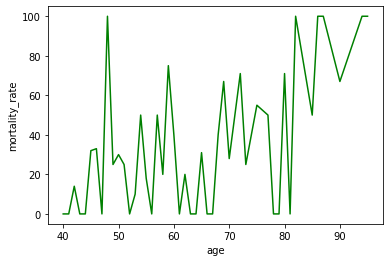

,number_of_death,number_of_observations,mortality_rate
creatinine_phosphokinase,,,
23,1,1,100.0
30,0,1,0.0
47,2,3,67.0
52,0,1,0.0
53,0,1,0.0
...,...,...,...
4540,0,1,0.0
5209,0,1,0.0
5882,1,1,100.0


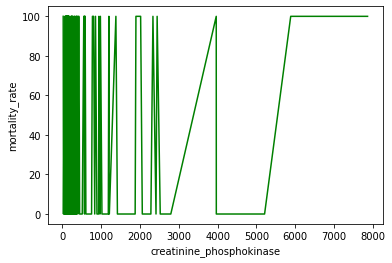

,number_of_death,number_of_observations,mortality_rate
ejection_fraction,,,
14,1,1,100.0
15,2,2,100.0
17,1,2,50.0
20,16,18,89.0
25,18,36,50.0
30,13,34,38.0
35,7,49,14.0
38,15,40,38.0
40,4,37,11.0


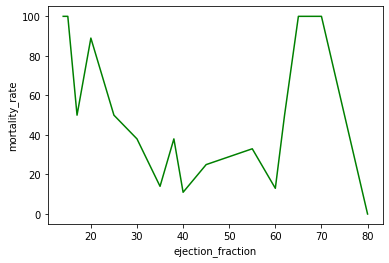

,number_of_death,number_of_observations,mortality_rate
platelets,,,
25100.0,0,1,0.0
47000.0,1,1,100.0
51000.0,0,1,0.0
62000.0,1,1,100.0
70000.0,1,1,100.0
...,...,...,...
533000.0,0,1,0.0
543000.0,0,1,0.0
621000.0,1,1,100.0


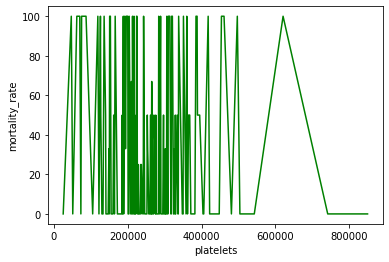

,number_of_death,number_of_observations,mortality_rate
serum_creatinine,,,
0.50,0,1,0.0
0.60,2,4,50.0
0.70,1,19,5.0
0.75,0,1,0.0
0.80,1,24,4.0
0.90,5,32,16.0
1.00,15,50,30.0
1.10,9,32,28.0
1.18,0,11,0.0


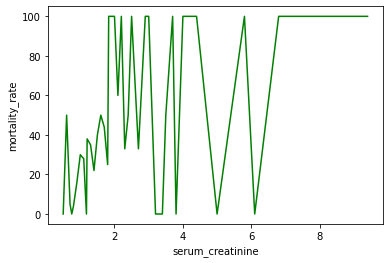

,number_of_death,number_of_observations,mortality_rate
serum_sodium,,,
113,0,1,0.0
116,1,1,100.0
121,1,1,100.0
124,1,1,100.0
125,0,1,0.0
126,0,1,0.0
127,3,3,100.0
128,1,2,50.0
129,2,2,100.0


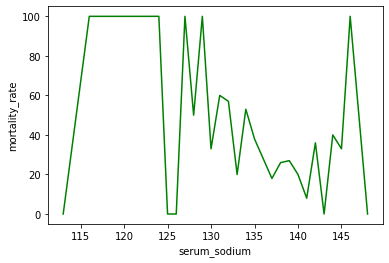

,number_of_death,number_of_observations,mortality_rate
time,,,
4,1,1,100.0
6,1,1,100.0
7,2,2,100.0
8,2,2,100.0
10,6,6,100.0
...,...,...,...
270,0,2,0.0
271,0,1,0.0
278,0,1,0.0


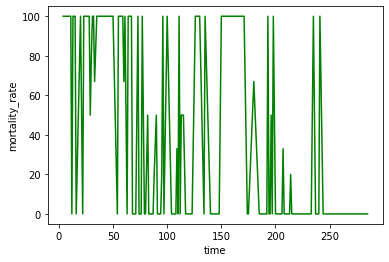

In [14]:
for i in range(len(list_of_numerical_features)):
    table = data.pivot_table(index=list_of_numerical_features[i], values='death_event', aggfunc=['sum','count'])
    table.columns = ['number_of_death','number_of_observations']
    table['mortality_rate'] = round(table['number_of_death']*100/table['number_of_observations'],0)
    display(table)
    #sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
    #title = list_of_categorical_features[i] + ' and death_event' 
    #plt.title(title)
    #plt.show()
    sns.lineplot(data=table, x=list_of_numerical_features[i], y='mortality_rate', color = 'g')
    plt.show()
    
    

Итак, у нас есть 5 категориальных бинарных признаков, таким образом, мы можем рассматривать пациентов сгрупированных по данным признакам, а группы разделить на подгруппы и расчитать процент смертности для каждой из них. На примере анемии: рассмотрим пациентов относительно данного признака, разделим их на две подгруппы, первая из которых - это все те пациенты, у кого была зафиксирована анемия, вторая, наоборот. В каждой из подгруп посчитаем процент смертности, оформим расчеты в сводную таблицу для удобства.

,number_of_death,number_of_observations,mortality_rate
anaemia,,,
0,50,170,0.294118
1,46,129,0.356589


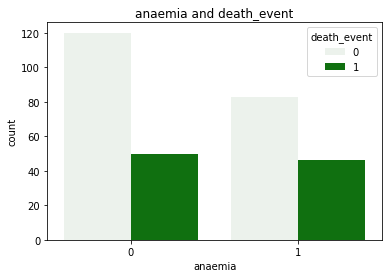

,number_of_death,number_of_observations,mortality_rate
diabetes,,,
0,56,174,0.321839
1,40,125,0.320000


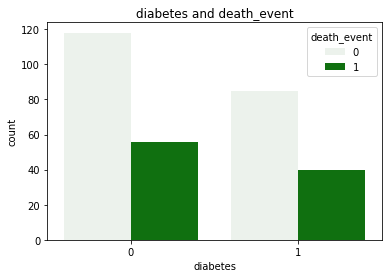

,number_of_death,number_of_observations,mortality_rate
high_blood_pressure,,,
0,57,194,0.293814
1,39,105,0.371429


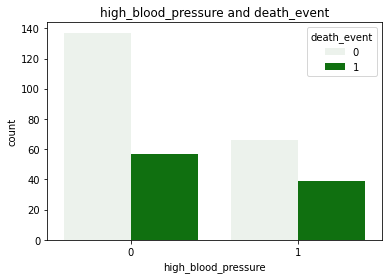

,number_of_death,number_of_observations,mortality_rate
sex,,,
0,34,105,0.323810
1,62,194,0.319588


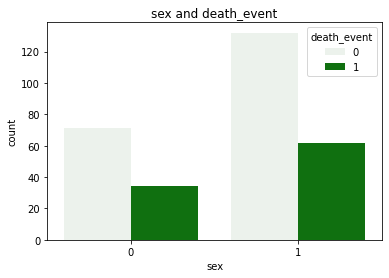

,number_of_death,number_of_observations,mortality_rate
smoking,,,
0,66,203,0.325123
1,30,96,0.312500


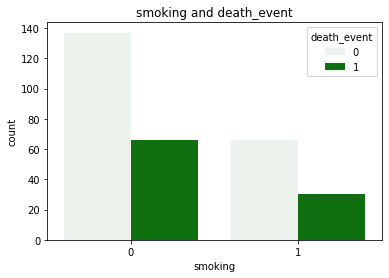

In [15]:
for i in range(len(list_of_categorical_features)-1):
    table = data.pivot_table(index=list_of_categorical_features[i], values='death_event', aggfunc=['sum','count'])
    table.columns = ['number_of_death','number_of_observations']
    table['mortality_rate'] = table['number_of_death']/table['number_of_observations']
    display(table)
    sns.countplot(x = data[list_of_categorical_features[i]],data=data, hue='death_event',color = 'g');
    title = list_of_categorical_features[i] + ' and death_event' 
    plt.title(title)
    plt.show()

1) Согласно графикам и расчетам в таблицах можно отметить следующее: риски смертности увеличивается при наличии анемии и высокого давления, диабет курение и пол не повышают риски;

2) Но, очень важно отметить, что имеется явный перекос в данных, на последнем примере это очень хорошо видно, подгруппа курящих пациентов более чем в два раза меньше подгруппы некурящих, это затрудняет сделать правильный вывод относительно смертности по данному признаку. Это распространяется и на другие группы;

3) Поэтому мы не можем с уверенностью считать, что наши выводы по пункту 1 корректны.

##### Категоризация времени, разбиение на недели.

In [16]:
data['time_week'] = (data['time']-1)//7
data.sample(8)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,time_week
227,55,1,2794,0,35,1,141000.0,1.00,140,1,0,206,0,29
124,60,0,582,0,40,0,217000.0,3.70,134,1,0,96,1,13
129,53,1,270,1,35,0,227000.0,3.40,145,1,0,105,0,14
271,51,0,582,1,40,0,221000.0,0.90,134,0,0,244,0,34
134,81,0,4540,0,35,0,231000.0,1.18,137,1,1,107,0,15
123,60,1,582,0,30,1,127000.0,0.90,145,0,0,95,0,13
95,58,1,133,0,60,1,219000.0,1.00,141,1,0,83,0,11
88,44,0,84,1,40,1,235000.0,0.70,139,1,0,79,0,11


In [17]:
df_time = pd.DataFrame()

df_time['death'] = data.groupby('time_week')['death_event'].sum()
df_time['count'] = data.groupby('time_week')['death_event'].count()
df_time['percent_of_death'] = round(df_time['death']*100/df_time['count'], 0)

df_time.sort_values(by='percent_of_death', ascending=False)

,death,count,percent_of_death
time_week,,,
0,4,4,100.0
18,2,2,100.0
5,4,4,100.0
6,5,5,100.0
23,1,1,100.0
1,13,14,93.0
3,9,10,90.0
9,5,6,83.0
2,4,5,80.0


<AxesSubplot:xlabel='time_week', ylabel='percent_of_death'>

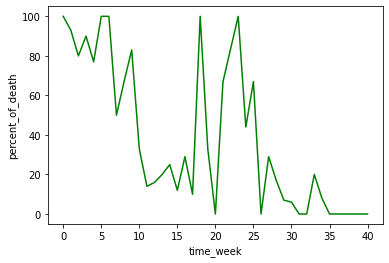

In [18]:
sns.lineplot(data=df_time, x="time_week", y="percent_of_death", color = 'g')

Вот так мы видим, что смертность выше 50% на промежутке наблюдения до 10 недель, между 21 и 24 неделями и на 18-й неделе.

Построим диаграмму размаха.

In [19]:
list_of_numerical_features = list_of_numerical_features + ['time_week']
list_of_numerical_features.remove('time')

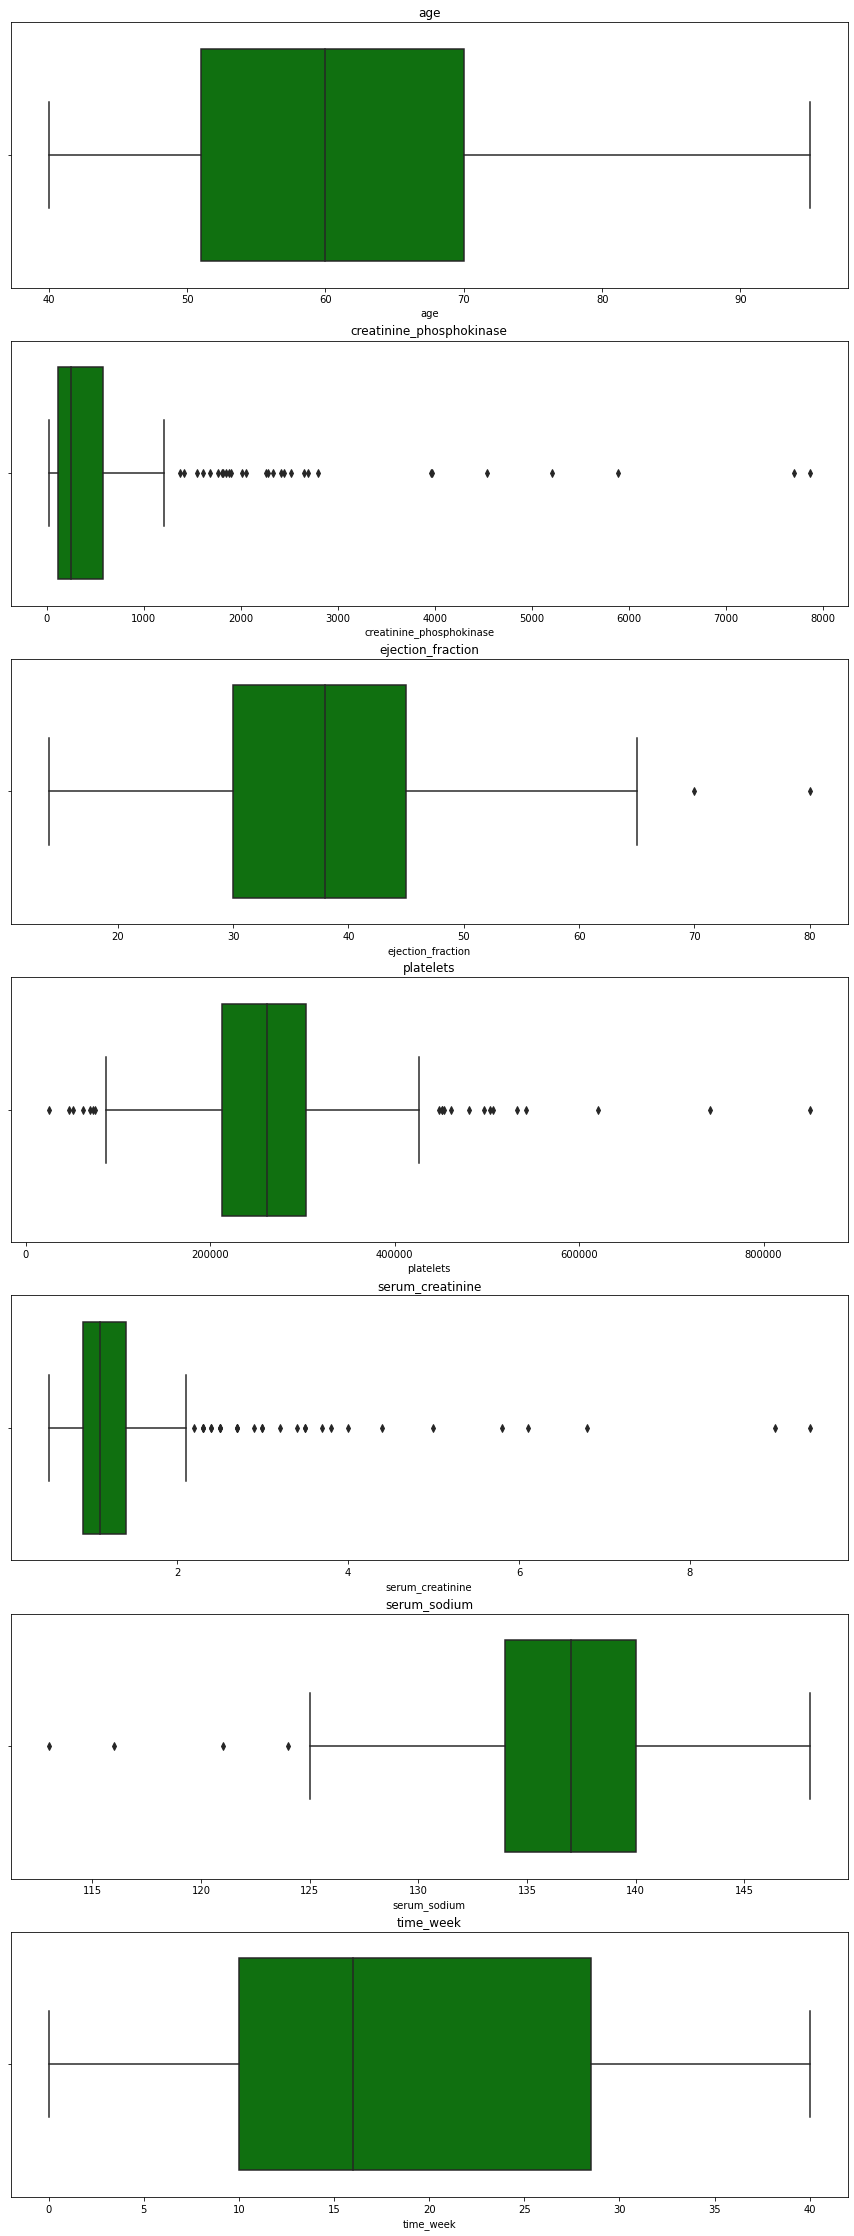

In [20]:
fig, ax = plt.subplots(nrows = 7,ncols = 1,figsize = (15,40))
for i in range(len(list_of_numerical_features)):
    plt.subplot(7,1,i+1)
    sns.boxplot(x=data[list_of_numerical_features[i]], color='g');
    title = list_of_numerical_features[i] 
    plt.title(title)

#### А стоит ли избавляться от выбросов?

#### Что можно делать с выбросами. Из сказанного на встрече и беседы с реальным программером, надо делать модель на хороших данных, а когда в реальности встречается ситуация, которую нельзя правильно предсказать моделью, её надо откладывать в отдельный датасет с пояснениями, что не так, а пользователю в этот момент выдавать рекомендации обратиться к специалисту по исследуемому вопросу, потому что программа некомпетентна в его случае.
Тут вопрос - а нам как с этим быть, ведь с такой  стороны мы ещё не заходили ни на одно задание.

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event,time_week
0,75,582,20,265000.00,1.9,130,1,0
1,55,7861,38,263358.03,1.1,136,1,0
2,65,146,20,162000.00,1.3,129,1,0
3,50,111,20,210000.00,1.9,137,1,0
4,65,160,20,327000.00,2.7,116,1,1
...,...,...,...,...,...,...,...,...
294,62,61,38,155000.00,1.1,143,0,38
295,55,1820,38,270000.00,1.2,139,0,38
296,45,2060,60,742000.00,0.8,138,0,39
297,45,2413,38,140000.00,1.4,140,0,39


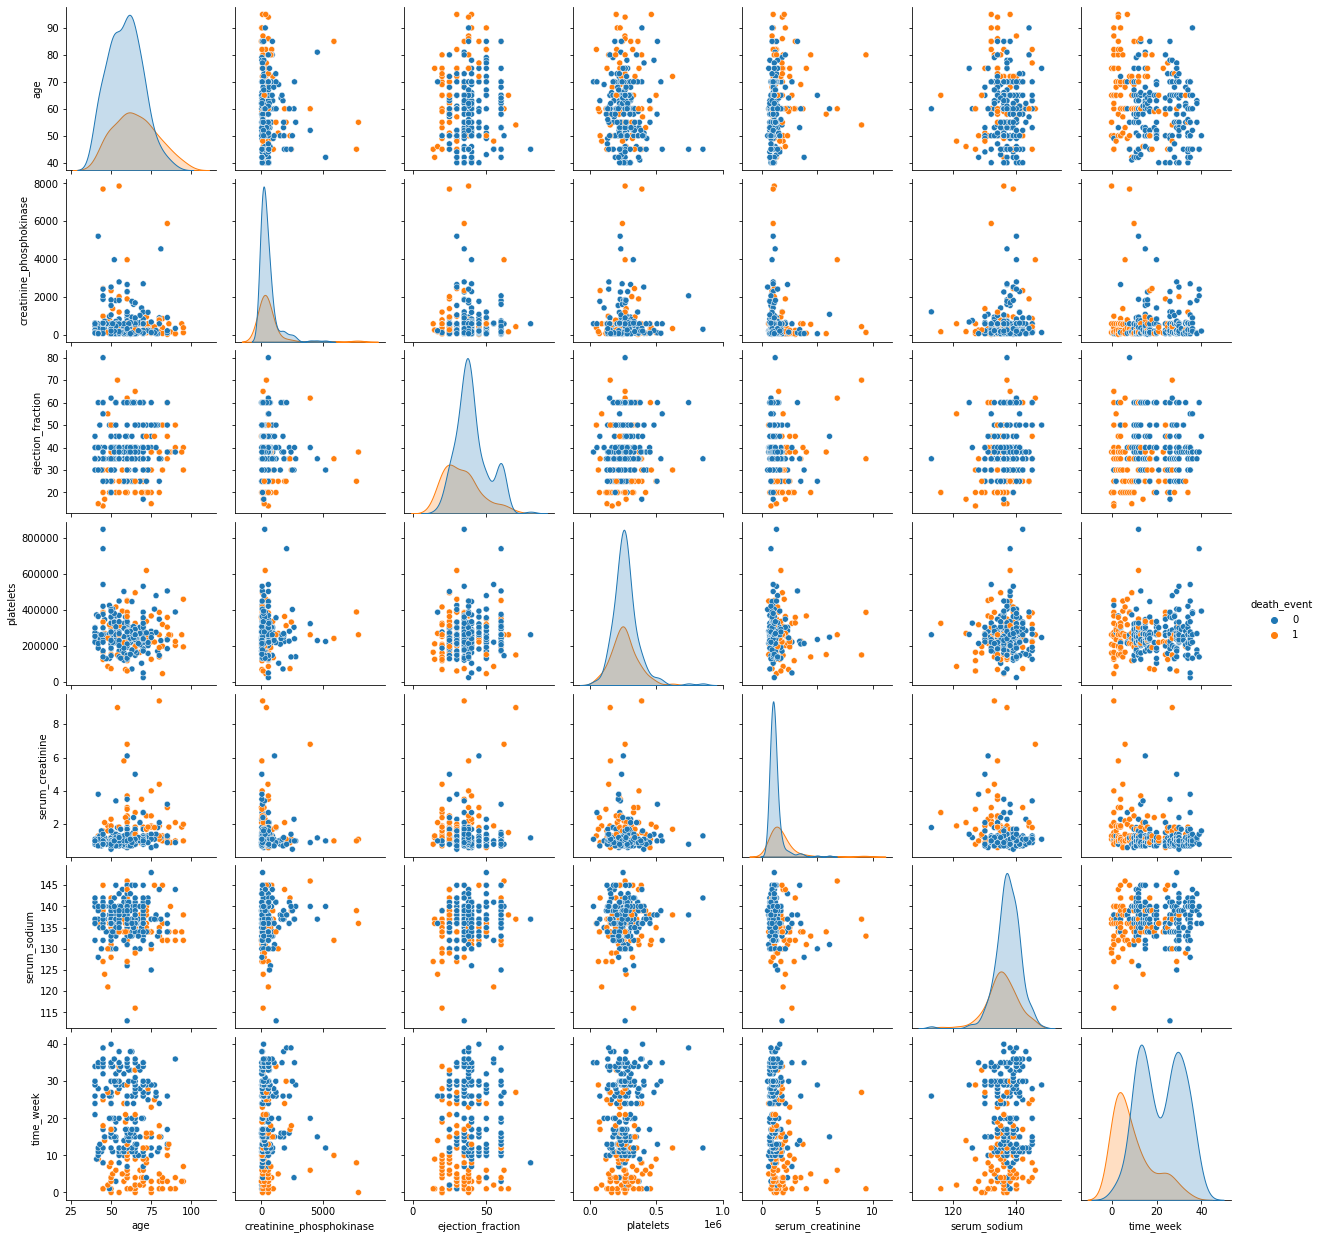

In [21]:
list_drop = list_of_categorical_features + ['time'] 
list_drop.remove('death_event')
data_numerical = data.drop(list_drop, axis=1)
display(data_numerical)
sns.pairplot(data_numerical, hue='death_event')

Видим, что данные кучкуются в некоторых параметрах (хорошо видно на времени наблюдения, как на первых неделях высока смертность, на объёме сердцебиения можно заметить). По диагональным распределениям можно сказать, что чем сильнее различаются кривые, тем заметней влияние величин друг на друга. Скорее всего, влияние параметра, связанного с тромбоцитами, будет несущественное, его можно исключить из параметров для обучения модели предсказания. Оранжевая кривая полностью скрывается под синей, симметрично и с максимумом на одной оси (визуально).

### Моделирование

 В переменных features_train, target_train и features_test,target_test сохраним данные для тренировки и теста, соответственно. 

In [22]:
features = data.drop(['death_event'], axis=1) # признаки
target = data['death_event'] # целевые признаки

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)
data_train, data_valid = train_test_split(data, test_size = 0.2, random_state = 12345, stratify=target)


В качестве метрик используем f1-score, roc_auc_score и recall.

#### Табличка для сохранения результатов - не знаю, как делать через датафрейм сразу,  есть опыт со списками и словарями, которые потом собираю в датафрейм. Думаю, её тут надо начать.

Приступим к обучению базовой модели (baseline model) , используя алгоритм классификации случайный лес и линейную регрессию.

#### Используем кросс-валидацию сразу - у нас мало ресурсов, откусили уже кусок, и она не влияет на качество модели, а позволяет просчитать среднюю метрику.

In [23]:
def print_scores(model, features, target):
    score_f1 = cross_val_score(model, features, target, scoring="f1", cv=5)
    score_recall = cross_val_score(model, features, target, scoring="recall", cv=5)
    score_roc_auc = cross_val_score(model, features, target, scoring="roc_auc", cv=5)

    print('Диапазон значений метрик:')
    print('f1-score:', score_f1)
    print("recall-score:", score_recall)
    print("roc-auc-score:", score_roc_auc)
    print('\nСредние значения метрик:')
    print('f1-score:', score_f1.mean())
    print("recall-score:", score_recall.mean())
    print("roc-auc-score:", score_roc_auc.mean())
    
    # думаю, тут не надо ничего возвращать :)
    # сюда можно встроить функцию записи в табличку/словарь/что-то ещё
    # тогда выбор модели потом можно осуществить на основе анализа этой таблички

In [24]:
# случайный лес
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
model_forest.fit(features_train, target_train)
# predicted = model.predict(features_test)
# print('f1-score:', f1_score(target_test, predicted))
# print("roc-auc-score:" , roc_auc_score(target_test, predicted))

print_scores(model_forest, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.63636364 0.66666667 0.82758621 0.8125     0.75862069]
recall-score: [0.46666667 0.6        0.8        0.92857143 0.78571429]
roc-auc-score: [0.92020202 0.8959596  0.92222222 0.95063025 0.92532468]

Средние значения метрик:
f1-score: 0.7403474399164054
recall-score: 0.7161904761904762
roc-auc-score: 0.9228677531618708


In [25]:
# логистическая регрессия
model_log = LogisticRegression(random_state=RANDOM_STATE)
model_log.fit(features_train, target_train)

print_scores(model_log, features_train, target_train)



Диапазон значений метрик:
f1-score: [0.60869565 0.68965517 0.64285714 0.59259259 0.88888889]
recall-score: [0.46666667 0.66666667 0.6        0.57142857 0.85714286]
roc-auc-score: [0.84242424 0.77575758 0.84646465 0.82563025 0.97402597]

Средние значения метрик:
f1-score: 0.6845378897852661
recall-score: 0.6323809523809524
roc-auc-score: 0.8528605381546557


По всем метрикам случайный лес опережает логистическую регрессию. 

In [26]:
model_cat = CatBoostClassifier(random_state=RANDOM_STATE, silent=True)
model_cat.fit(features_train, target_train)

print_scores(model_cat, features_train, target_train)


Диапазон значений метрик:
f1-score: [0.63636364 0.66666667 0.85714286 0.8        0.68965517]
recall-score: [0.46666667 0.6        0.8        0.85714286 0.71428571]
roc-auc-score: [0.93333333 0.87474747 0.9030303  0.95378151 0.93506494]

Средние значения метрик:
f1-score: 0.7299656665173906
recall-score: 0.6876190476190477
roc-auc-score: 0.9199915117562177


И даже catBoost справляется хуже случайного леса.

### Подбор параметров
Подберём параметры для каждой модели. Критериам будет метрика recall.

In [27]:
# баланс классов
target_train.value_counts(normalize=True)

0    0.694561
1    0.305439
Name: death_event, dtype: float64

#### случайный лес

In [28]:
parameters = {'n_estimators' : [1, 1000], 'max_depth' : [1, 10], 'bootstrap' : ('True', 'False')}

grid_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), parameters, scoring="recall", cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_forest.fit(features_train, target_train)

grid_forest.best_params_

{'bootstrap': 'True', 'max_depth': 10, 'n_estimators': 1000}

In [29]:
model_forest = RandomForestClassifier(n_estimators=grid_forest.best_params_.get('n_estimators'),\
                                      max_depth=grid_forest.best_params_.get('max_depth'),\
                                      bootstrap=grid_forest.best_params_.get('bootstrap'))

print_scores(model_forest, features_train, target_train)

Диапазон значений метрик:
f1-score: [0.69565217 0.66666667 0.85714286 0.8        0.71428571]
recall-score: [0.53333333 0.6        0.8        0.85714286 0.71428571]
roc-auc-score: [0.92727273 0.88282828 0.89494949 0.95168067 0.92207792]

Средние значения метрик:
f1-score: 0.7467494824016563
recall-score: 0.700952380952381
roc-auc-score: 0.915761819879467


#### логистическая регрессия

In [30]:
parameters = {'solver':('liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'), 'max_iter':[1,1000],\
              'class_weight':('balanced', 'None', [0.30, 0.70], [0.70, 0.30])}  

grid_log = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), parameters, scoring="recall", cv = 5, n_jobs= -1)
grid_log.fit(features_train, target_train)

grid_log.best_params_

{'class_weight': 'balanced', 'max_iter': 1, 'solver': 'sag'}

In [31]:
model_log = LogisticRegression(solver=grid_log.best_params_.get('solver'),\
                               max_iter=grid_log.best_params_.get('max_iter'),\
                               class_weight=grid_log.best_params_.get('class_weight'))

print_scores(model_log, features_train, target_train)

Диапазон значений метрик:
f1-score: [0.47619048 0.47619048 0.47619048 0.4516129  0.        ]
recall-score: [0. 0. 0. 1. 0.]
roc-auc-score: [0.46464646 0.24646465 0.3979798  0.42226891 0.67099567]

Средние значения метрик:
f1-score: 0.376036866359447
recall-score: 0.2
roc-auc-score: 0.440471097529921


#### CatBoost

In [32]:
parameters_cat = {'l2_leaf_reg': [1, 15], 'iterations' : [1, 1000],\
                          'learning_rate':[0.03, 0.07, 0.1, 0.13, 0.17],\
                          'max_depth' : [1, 10]}

grid_cat = GridSearchCV(CatBoostClassifier(random_state=RANDOM_STATE),\
                        parameters_cat, scoring="recall",  cv = 5, n_jobs= -1)
grid_cat.fit(features_train, target_train, silent=True)
grid_cat.best_params_

{'iterations': 1000, 'l2_leaf_reg': 15, 'learning_rate': 0.1, 'max_depth': 1}

In [33]:
model_cat = CatBoostClassifier(l2_leaf_reg=grid_cat.best_params_.get('l2_leaf_reg'),\
                               iterations=grid_cat.best_params_.get('iterations'),\
                               learning_rate=grid_cat.best_params_.get('learning_rate'),\
                               max_depth=grid_cat.best_params_.get('max_depth'),\
                               random_state=RANDOM_STATE, silent=True)

print_scores(model_cat, features_train, target_train)

Диапазон значений метрик:
f1-score: [0.69565217 0.68965517 0.73333333 0.77419355 0.73333333]
recall-score: [0.53333333 0.66666667 0.73333333 0.85714286 0.78571429]
roc-auc-score: [0.9030303  0.88686869 0.90707071 0.93067227 0.89393939]

Средние значения метрик:
f1-score: 0.7252335122761201
recall-score: 0.7152380952380952
roc-auc-score: 0.9043162719633309


### Тестирование

Лес - модель выбора и по recall, и по f1.

In [43]:
model_forest.fit(features_train, target_train)
predicted_test = model_forest.predict(features_test)

print('f1-score:', f1_score(target_test, predicted_test))
print('recall-score:', recall_score(target_test, predicted_test))
print("roc-auc-score:" , roc_auc_score(target_test, predicted_test))

f1-score: 0.7317073170731708
recall-score: 0.6521739130434783
roc-auc-score: 0.7855464159811986


Модельные значения:
f1-score: 0.7467494824016563
recall-score: 0.700952380952381
roc-auc-score: 0.915761819879467

Падение f1 несущественно, recall - тоже можно смириться, а roc-auc как-то съехал.
Поскольку можно менять метрику, по которой подбираются параметры, можно по всем трём пройтись и сделать тогда уже выводы. Эти значения получены для модели, у которой параметры подобраны по метрике recall, логично смотреть на неё же при выводе, имхо. Давай обсуждать.

#### Мы не провели категоризацию двух признаков creatinine_phosphokinase и platelets еще до обучения- для визуализации

#### Так, причёсываем оставшиеся строки по выбросам на основании оставшихся данных же, правильно? Мы как будто бы не знаем, что нам там прилетит в тесте, а у нас есть только то, что в трейне.

In [34]:
#len(features_train) # зафиксировать размер, чтоб понять, сколько строк ушло.

In [35]:
def del_quantile(df, param_name):
    q1 = df[param_name].quantile(.25)
    q3 = df[param_name].quantile(.75)

    q0 = q1 - (q3-q1)*1.5
    q4 = q3 + (q3-q1)*1.5

    return df.loc[(df[param_name]>q0) & (df[param_name]<q4)]

In [36]:
#for item in list_of_numerical_features:
#    features_train = del_quantile(features_train, item)

In [37]:
#len(features_train)

#### Важное замечание
Смотри, какая разница. Это неправильно. Каждый раз функция получает изменённый датасет и считает по остаткам квантили, хотя в остатках уже совсем другие значения. Если нам надо обрезать выбросы, то надо либо вручную, либо на вход подавать один и тот же сет, а на выходе брать, например, список индексов. Потом по всем спискам индексов подобрать только такие строки, чьи номера встречаются во всех списках.

А так мы теряем 25 % оставшихся данных. 

upd Я закомментировала эту обрезку, там было 239 строк, а стало 181.

